# Project: Mobile App User Behavior Analysis

**A task:
Explore the sales funnel. Find out how users reach a purchase. How many users reach the purchase, and how many get stuck on the previous steps, on which ones.
examine the results of the A/A/B experiment and decide whether the font in the application is worth me. Find out which font is best.**

Work plan:
1. General information.
2. Data preprocessing.
3. Data validation and analysis.
4. Event funnels.
5. Analysis of the results of the experiment.
6. General conclusion.

# 1. General information

In [132]:
import pandas as pd
import numpy as np
import math as mth
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st


In [133]:
df = pd.read_csv('C:/Users/sony/Downloads/logs_exp.csv', sep='\t')

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [135]:
df.sample(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
52601,OffersScreenAppear,7753775826753824773,1564742573,248
160723,PaymentScreenSuccessful,6613527411922640441,1565013854,246
101367,PaymentScreenSuccessful,4403500226957059119,1564851938,247
155661,MainScreenAppear,1935778368501008203,1565006071,246
107116,MainScreenAppear,8729942814780019809,1564865896,246
69146,OffersScreenAppear,3960281369461151687,1564769620,247
226520,MainScreenAppear,2458697374193262776,1565179175,248
103040,OffersScreenAppear,3063248032210795834,1564854970,247
73655,CartScreenAppear,6304868067479728361,1564779973,248
15987,MainScreenAppear,8107103883478813949,1564658354,246


## 2.Data preprocessing.

In [136]:
#implicit duplicates
df['EventName'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [137]:
#experimental groups
df['ExpId'].unique()

array([246, 248, 247], dtype=int64)

In [138]:
df.duplicated().sum()

413

In [139]:
df = df.drop_duplicates().reset_index(drop=True)

In [140]:
df.isna().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

In [141]:
#rename columns
df.columns= ['event_name','device_id', 'event_date','group']

In [142]:
df['event_date'] = pd.to_datetime(df['event_date'], unit='s')

In [143]:
#add a date column
df['date'] = pd.DatetimeIndex(df['event_date']).date

In [144]:
df.head()

,event_name,device_id,event_date,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [145]:
#change data type
df['device_id'] = df['device_id'].astype('str')
df['group'] = df['group'].astype('str')

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   device_id   243713 non-null  object        
 2   event_date  243713 non-null  datetime64[ns]
 3   group       243713 non-null  object        
 4   date        243713 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 9.3+ MB


## 3.Data validation and analysis.

In [147]:
df.shape[0]

243713

Let's check how many users are in the log

In [148]:
df['device_id'].nunique()

7551

Let's check how many events per user on average

In [149]:
event_mean = round(df['event_name'].count()/df['device_id'].nunique())
event_mean

32

Average 32 events per user

start of the test

In [150]:
df['event_date'].min()

Timestamp('2019-07-25 04:43:36')

end of the test

In [151]:
df['event_date'].max()

Timestamp('2019-08-07 21:15:17')

lets check period  of the data

In [152]:
days_space = (df['event_date'].max()-df['event_date'].min())
days_space

Timedelta('13 days 16:31:41')

''

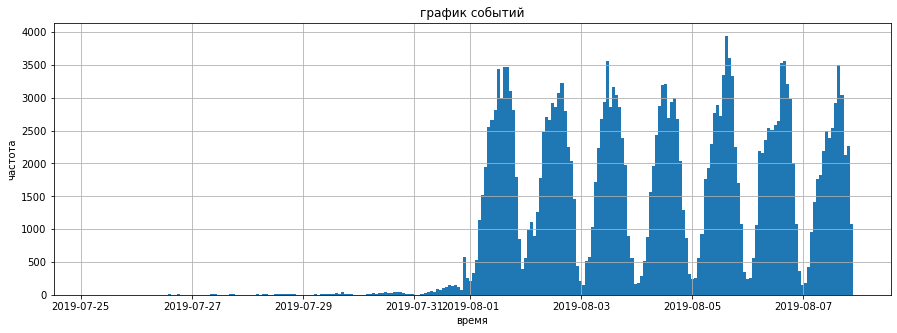

In [153]:
#histogram by date time
df['event_date'].hist(bins = 250, figsize=(15,5))
plt.title("график событий")
plt.xlabel("время")
plt.ylabel("частота")
;

**Conclusion: according to the hist, we see that the data is incomplete until August 1, I think that it is worth cutting off the data until this day in order not to take into account possible incorrect or incomplete data**


In [154]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   device_id   243713 non-null  object        
 2   event_date  243713 non-null  datetime64[ns]
 3   group       243713 non-null  object        
 4   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(3)
memory usage: 9.3+ MB


In [155]:
df[df['date'] > '2019-08-01']['event_name'].count()

204746

In [156]:
#check how much data we lost during the period that we cut off
dif = df['date'].count() - df[df['date'] > '2019-08-01']['date'].count()
dif

38967

In [157]:
df[df['date'] <= '2019-07-31'].groupby('date')[['device_id','event_name']].nunique().sum().to_frame()

,0
device_id,1492
event_name,31


In [158]:
#Let's discard the old data
df = df[df['date'] > '2019-08-01']

check the data period after discarding unnecessary days

In [159]:
#actual period
days_actual = (df['event_date'].max()-df['event_date'].min())
days_actual

Timedelta('5 days 21:15:17')

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204746 entries, 38967 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  204746 non-null  object        
 1   device_id   204746 non-null  object        
 2   event_date  204746 non-null  datetime64[ns]
 3   group       204746 non-null  object        
 4   date        204746 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(3)
memory usage: 9.4+ MB


In [161]:
df['event_name'].count()

204746

## 4. Изучение воронки событий.

Let's check what events are in the logs and how often they occur

In [162]:
df1= df.pivot_table(index='event_name', values='device_id', aggfunc='nunique', sort=True).sort_values(by='device_id', ascending=False)
df1

,device_id
event_name,
MainScreenAppear,7156
OffersScreenAppear,4380
CartScreenAppear,3571
PaymentScreenSuccessful,3399
Tutorial,690


lets check shares by events

In [163]:
df['event_name'].value_counts(normalize = True).round(3).reset_index()

,index,event_name
0,MainScreenAppear,0.485
1,OffersScreenAppear,0.192
2,CartScreenAppear,0.176
3,PaymentScreenSuccessful,0.142
4,Tutorial,0.004


I think that the tutorial can be removed from processing as it is an independent rare event

In [164]:
df1 = df1[:4].copy()

In [165]:
df1

,device_id
event_name,
MainScreenAppear,7156
OffersScreenAppear,4380
CartScreenAppear,3571
PaymentScreenSuccessful,3399


check the proportion of users who have ever made an event

In [166]:
df1['percent, %'] = round(df1['device_id']/df1['device_id'][0]*100)
df1

,device_id,"percent, %"
event_name,,
MainScreenAppear,7156,100.0
OffersScreenAppear,4380,61.0
CartScreenAppear,3571,50.0
PaymentScreenSuccessful,3399,47.0


So the events happen in the following orde:
1. main screen
2. offer screen
3. cart screen
4. payment screen

In [167]:
# Let's calculate what proportion goes to the next step of the funnel
df1['shift'] = df1['device_id'].shift(1)
df1

,device_id,"percent, %",shift
event_name,,,
MainScreenAppear,7156,100.0,NaN
OffersScreenAppear,4380,61.0,7156.0
CartScreenAppear,3571,50.0,4380.0
PaymentScreenSuccessful,3399,47.0,3571.0


In [168]:
df1['step'] = round(df1['device_id']/df1['shift']*100)
df1

,device_id,"percent, %",shift,step
event_name,,,,
MainScreenAppear,7156,100.0,NaN,NaN
OffersScreenAppear,4380,61.0,7156.0,61.0
CartScreenAppear,3571,50.0,4380.0,82.0
PaymentScreenSuccessful,3399,47.0,3571.0,95.0


conclusion: most users is lost in the first step after viewing the main screen. 39%
From the moment of the first event to payment, 47% of users reach

## 5. Analysis of the results of the experiment

In [169]:
#let's check how many users are in each experimental group
df[df['event_name'] == 'MainScreenAppear'].groupby('group').agg({'device_id': 'nunique'})

,device_id
group,
246,2355
247,2392
248,2409


In [170]:
df[df['event_name'] == 'PaymentScreenSuccessful'].groupby('group').agg({'device_id': 'nunique'})

,device_id
group,
246,1152
247,1118
248,1129


In [171]:
#Add a merged group '246+247'
funnels = df.pivot_table(index='event_name', columns='group',values='device_id',aggfunc='nunique')\
                       .sort_values('246',ascending=False)
funnels['246+247'] = funnels['246'] + funnels['247']
funnels.drop(['Tutorial'], inplace=True)
funnels

group,246,247,248,246+247
event_name,,,,
MainScreenAppear,2355,2392,2409,4747
OffersScreenAppear,1480,1438,1462,2918
CartScreenAppear,1213,1184,1174,2397
PaymentScreenSuccessful,1152,1118,1129,2270


In [172]:
#make a table to account for the total number of users
users = df.groupby('group')['device_id'].nunique().to_frame()
users

,device_id
group,
246,2393
247,2434
248,2459


In [173]:
#add a row with the combined group
users = users.reset_index()
users.loc[3] = ['246+247', 4827]
users = users.set_index(users.columns[0])
users

,device_id
group,
246,2393
247,2434
248,2459
246+247,4827


In [174]:
#function for finding statistical significance between compared groups
def z_test(exp1, exp2, event, alpha): 
    p1_ev = funnels.loc[event, exp1]
    p2_ev = funnels.loc[event, exp2] 
    p1_us = users.loc[exp1, 'device_id'] 
    p2_us = users.loc[exp2, 'device_id'] 
    p1 = p1_ev / p1_us 
    p2 = p2_ev / p2_us 
    difference = p1 - p2
    p_combined = (p1_ev + p2_ev) / (p1_us + p2_us) 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / p1_us + 1 / p2_us))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Check for  {} and {}, event: {}, p-value: {p_value:.2f}'.format(exp1, exp2, event, p_value=p_value))
    if (p_value < alpha):
        print("Rejecting the null hypothesis")
    else:
        print("Failed to reject the null hypothesis")

Lets find the statistical significance between the control groups (246 and 247) for each funnel step.
H0 - groups have no statistically significant difference. H1 - there is a statistically significant difference between the groups.
the level of statistical significance is defined as Alpha = 0.05.

In [175]:
for event in funnels.index:
    z_test('246', '247', event, 0.05)
    print()

Check for  246 and 247, event: MainScreenAppear, p-value: 0.71
Failed to reject the null hypothesis

Check for  246 and 247, event: OffersScreenAppear, p-value: 0.05
Rejecting the null hypothesis

Check for  246 and 247, event: CartScreenAppear, p-value: 0.16
Failed to reject the null hypothesis

Check for  246 and 247, event: PaymentScreenSuccessful, p-value: 0.12
Failed to reject the null hypothesis



**Conclusion:
there is a statistically significant difference between the control groups in the second step (suggestion screen) of the funnel**

Lets find the statistical significance between the control group 246 and the experimental group 248 for each step of the funnel. The level of statistical significance is defined as Alpha =0.05.
H0 - there is no statistically significant difference between the groups. H1 - groups differ from each other.

In [176]:
for event in funnels.index:
    z_test('246', '248', event, 0.05)
    print()

Check for  246 and 248, event: MainScreenAppear, p-value: 0.25
Failed to reject the null hypothesis

Check for  246 and 248, event: OffersScreenAppear, p-value: 0.09
Failed to reject the null hypothesis

Check for  246 and 248, event: CartScreenAppear, p-value: 0.04
Rejecting the null hypothesis

Check for  246 and 248, event: PaymentScreenSuccessful, p-value: 0.12
Failed to reject the null hypothesis



**Conclusion: there is a statistically significant difference between the groups at the third step of the funnel (basket screen).**

Lets find the statistical significance between the control group 247 and the experimental group 248 for each step of the funnel. The level of statistical significance is defined as Alpha =0.05.
H0 - there is no statistically significant difference between the groups. H1 - groups differ from each other.

In [177]:
for event in funnels.index:
    z_test('247', '248', event, 0.05)
    print()

Check for  247 and 248, event: MainScreenAppear, p-value: 0.43
Failed to reject the null hypothesis

Check for  247 and 248, event: OffersScreenAppear, p-value: 0.79
Failed to reject the null hypothesis

Check for  247 and 248, event: CartScreenAppear, p-value: 0.53
Failed to reject the null hypothesis

Check for  247 and 248, event: PaymentScreenSuccessful, p-value: 0.99
Failed to reject the null hypothesis



**Conclusion: there is no statistically significant difference between the compared groups.**

Lets find the statistical significance between the pooled control group 246-247 and the experimental group 248 for each funnel step. The level of statistical significance is defined as Alpha =0.05.
H0 - there is no statistically significant difference between the groups. H1 - groups differ from each other.

In [178]:
for event in funnels.index:
    z_test('246+247', '248', event, 0.05)
    print()

Check for  246+247 and 248, event: MainScreenAppear, p-value: 0.25
Failed to reject the null hypothesis

Check for  246+247 and 248, event: OffersScreenAppear, p-value: 0.41
Failed to reject the null hypothesis

Check for  246+247 and 248, event: CartScreenAppear, p-value: 0.12
Failed to reject the null hypothesis

Check for  246+247 and 248, event: PaymentScreenSuccessful, p-value: 0.37
Failed to reject the null hypothesis



**Conclusion: there is no statistically significant difference between the compared groups.**

## 6. General conclusion.

As a result of the study, we performed 4 **AA** tests and 12 **AB** tests. 
* The sensitivity criterion is set at 0.05. I see no reason to make criteria at 0.01, since the test results show that everything is visible with a criterion of 0.05.
Thus, from the measurement results, it can be seen that:
* there are no statistical data on the differences between the control loads and the experimental load, the difference between the control loads in the second stage of the funnel
* confusing, but I think that it is important to look at the conversion in the first step and in the payment step, since they are present in most cases. Signs and effects of business.
* you can achieve a steep conversion per step, but if the conversion into a purchase remains unchanged, then you won’t be able to call such work effective. Therefore, I believe that the experiment can be considered unsuccessful and proceed to test other hypotheses.